## Image Classification based on butterflies dataset using transfer learning

In [1]:
import torch 
from torchvision import models
import torchvision 
from torchvision.datasets import ImageFolder
import torchvision.transforms as tfm
from tqdm import tqdm
import matplotlib.pyplot as plt 
from torch.utils.data import DataLoader 
import numpy as np 

%matplotlib inline 

### Dataset comes from: https://www.kaggle.com/gpiosenka/butterfly-images40-species 

In [2]:
# this is the mean and std for ImageNet dataset
Mean = np.asarray([ 0.485, 0.456, 0.406 ])
Std = np.asarray([ 0.229, 0.224, 0.225 ])

In [3]:
train_tfms = tfm.Compose([tfm.RandomCrop(224, padding=4, padding_mode='reflect'), 
                         tfm.RandomHorizontalFlip(0.5),                          
                         tfm.RandomVerticalFlip(0.6),
                         tfm.ToTensor(), 
                         tfm.Normalize(mean=Mean, std=Std, inplace=True), # normalize image based on mean and std of ImageNet dataset
                         tfm.Lambda(lambda x: x.mul(255.))
                         ])
test_tfms = tfm.Compose([
    tfm.ToTensor(),
    tfm.Normalize(mean=Mean, std=Std, inplace=True), # normalize image based on mean and std of ImageNet dataset
    tfm.Lambda(lambda x: x.mul(255.))
])

In [4]:
from PIL import Image

load_tfms = tfm.Compose([
    tfm.Resize((224,224)), 
    tfm.ToTensor(),
    tfm.Normalize(Mean, Std, inplace=True), # normalize image based on mean and std of ImageNet dataset
    tfm.Lambda(lambda x: x.mul(255.))
    ])

def loadPicture(path):    
    image = Image.open(path).convert('RGB')    
    img=load_tfms(image)    
    plt.imshow(image)
    return img 

In [5]:
def showTensorImage(image):
    tfm=transforms.Compose([
        # reverse the normalization
        transforms.Lambda(lambda x: x.div(255.) ), 
        transforms.Normalize((-1 * Mean / Std), (1.0 / Std),inplace=True) 
        ])
    img=tfm(image)
    plt.figure(figsize=(10,10) )
    plt.imshow(img.permute(1,2,0))

In [6]:
root='archive/butterflies_rev2'

trainDS=ImageFolder(f'{root}/train', transform=train_tfms)
valDS=ImageFolder(f'{root}/valid', transform=train_tfms)
testDS=ImageFolder(f'{root}/test', transform=test_tfms)
print(f'train ds has {len(trainDS)},  val ds has {len(valDS) } and testDS has {len(testDS)} items with {len(trainDS.classes)} classes')
img, _=trainDS[1]
print(img.shape)

train ds has 4955,  val ds has 250 and testDS has 250 items with 50 classes
torch.Size([3, 224, 224])


### Let's look at some samples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


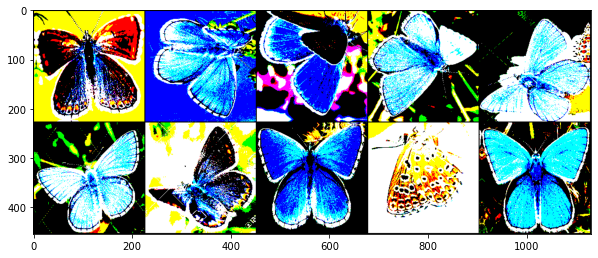

In [7]:
from torchvision.utils import make_grid
num_images=10
images = [trainDS[idx][0] for idx in range(num_images)]
plt.figure(figsize=(10,10) )

image_grid = make_grid(images, nrow=num_images//2)            
plt.imshow(image_grid.permute(1, 2, 0).squeeze(0))    


In [8]:
def getDataLoaders(batchSize):
    trainldr=DataLoader(trainDS, shuffle=True, num_workers=4, pin_memory=True, batch_size=batchSize ) 
    valldr=DataLoader(valDS, num_workers=4, pin_memory=True, batch_size=batchSize)
    testldr=DataLoader(testDS,num_workers=4, pin_memory=True, batch_size=batchSize)

    return trainldr, valldr, testldr 

## Import the resnet model from model zoo
Transfer learning has 2 modes: 
1. fine tuning: pretrained model used as a starting point to continue training for new classes
2. feature extractor: weights are frozen. only final linear is trained

In [9]:
def getModel(ntwkType=0, frozen=True):
    model=None 
    
    if ntwkType==0:
        model=models.resnet18(pretrained=True)        
    elif ntwkType==1:        
        model=models.resnet34(pretrained=True)
    elif ntwkType==2:
        model=models.resnet50(pretrained=True)
    elif ntwkType==3:
        model=models.resnet101(pretrained=True)
    elif ntwkType==4:
        model=models.resnet152(pretrained=True)        
        
    inputs=model.fc.in_features
    if frozen:        
        for param in model.parameters():
            param.requires_grad=False
    model.fc=torch.nn.Linear(inputs, len(trainDS.classes) )
    return model 


In [10]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model=getModel(1,False)
model.to(device)

cuda


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
def save(model, path):
    torch.save(model, path)

In [12]:
def getAccuracy(outputs, labels):
    preds=torch.argmax(outputs, dim=1)
    return torch.sum(preds==labels).item()

In [13]:
import torch.nn.functional as F  

def train(ldr, opt, sched=None):    
    num_items=0
    losses=0.
    accs=0.
    model.train()
    for batch in tqdm(ldr):        
        opt.zero_grad()        
        imgs, lbls=batch 
        num_items+=len(lbls)
        imgs=imgs.to(device)
        lbls=lbls.to(device)
        outputs=model(imgs)
        loss=F.cross_entropy(outputs, lbls)
        losses+=(loss.item()*len(lbls))
        accs+=getAccuracy(outputs, lbls)
        loss.backward()        
        opt.step()
        if sched is not None:
            sched.step()
    return losses/num_items, accs/num_items 


In [14]:
def evaluate(ldr, trainedModel):
    size=0
    losses=0. 
    accs=0. 
    trainedModel.eval()
    for batch in tqdm(ldr):
        imgs, lbls=batch 
        size+=len(lbls)
        imgs=imgs.to(device )
        lbls=lbls.to(device )
        outputs=trainedModel(imgs)
        loss=F.cross_entropy(outputs, lbls)
        losses+=(loss.item()*len(lbls))
        accs+=getAccuracy(outputs, lbls)
    return losses/size , accs/size 

In [15]:
import torch.optim as optim 

batchsize=256
lr=5e-5
epochs=25

opt=optim.Adam(model.parameters(), lr=lr)
trainLdr, valLdr, testLdr =getDataLoaders(batchsize)
sched = torch.optim.lr_scheduler.OneCycleLR(opt,max_lr=lr*5, epochs=epochs,steps_per_epoch=len(trainLdr))

In [16]:
import  IPython.display as display 

def showResults(tloss, tacc, vloss, vacc):
    display.clear_output(wait=True )
    print('epoch\t TLosses\t TAccs\t\t VLosses\t VAccs')
    print('------------------------------------------------------------')
    for i in range(len(tloss)):
        print(f'{i+1}\t {tloss[i]:.3f}\t\t {tacc[i]*100.:.3f}% \t {vloss[i]:.3f}\t\t {vacc[i]*100.:.3f}%')

In [17]:
trainLosses=[]
trainAccs=[]
valLosses=[]
valAccs=[]
curValAcc=0.

for ep in range(epochs):
    print(f'\nTraining {ep+1}/{epochs}')
    losses, accs=train(trainLdr, opt, sched)
    trainLosses+=[losses]
    trainAccs+=[accs]
    print(f'Validating {ep+1}/{epochs}')
    losses, accs=evaluate(valLdr, model)
    valLosses+=[losses]
    valAccs+=[accs]
    if accs>curValAcc:
        save(model, 'model.pth')
        curValAcc=accs
    showResults(trainLosses, trainAccs, valLosses, valAccs)

epoch	 TLosses	 TAccs		 VLosses	 VAccs
------------------------------------------------------------
1	 3.946		 3.713% 	 3.610		 8.400%
2	 3.070		 32.735% 	 2.265		 61.600%
3	 1.634		 77.296% 	 0.873		 86.800%
4	 0.600		 90.333% 	 0.339		 94.400%
5	 0.251		 95.358% 	 0.195		 96.000%
6	 0.151		 96.650% 	 0.200		 94.800%
7	 0.113		 97.316% 	 0.147		 97.200%
8	 0.085		 98.083% 	 0.140		 97.600%
9	 0.070		 98.507% 	 0.149		 96.400%
10	 0.056		 98.648% 	 0.124		 97.200%
11	 0.043		 98.910% 	 0.125		 96.000%
12	 0.034		 99.112% 	 0.109		 98.000%
13	 0.032		 99.233% 	 0.108		 96.800%
14	 0.020		 99.576% 	 0.114		 96.800%
15	 0.019		 99.536% 	 0.103		 97.200%
16	 0.015		 99.657% 	 0.072		 98.400%
17	 0.013		 99.758% 	 0.061		 98.000%
18	 0.010		 99.818% 	 0.076		 98.000%
19	 0.007		 99.899% 	 0.082		 98.000%
20	 0.008		 99.879% 	 0.076		 98.000%
21	 0.008		 99.818% 	 0.065		 98.400%
22	 0.007		 99.859% 	 0.075		 98.000%
23	 0.005		 99.939% 	 0.083		 98.000%
24	 0.006		 99.899% 	 0.058		 98.400%

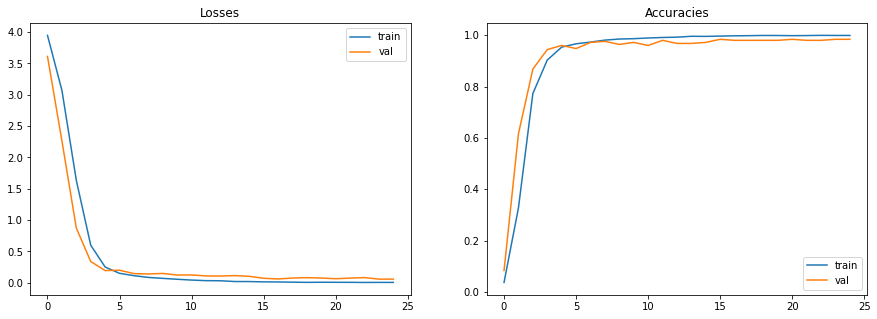

In [18]:
fig=plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.title('Losses')
plt.plot(trainLosses, label='train')
plt.plot(valLosses, label='val')
plt.legend()
plt.subplot(1, 2, 2)
plt.title('Accuracies')
plt.plot(trainAccs, label='train')
plt.plot(valAccs, label='val')
plt.legend()

plt.show()

## load the best performing weights from training

In [19]:
model2=torch.load('model.pth')
model2.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
losses, accs=evaluate(testLdr,model2)
print(f'Test Losses={losses:.3f}, accuracies={accs*100. : .2f} % ')

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.07s/it]

Test Losses=0.092, accuracies= 97.60 % 


## Inferencing with images containing various fruits

iimg shape: torch.Size([3, 224, 224]) 


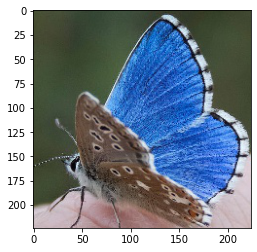

In [21]:

img='2.jpg'
path=f'{root}/images to predict/{img}'
img=loadPicture(path)
print(f'iimg shape: {img.shape} ')

In [22]:
def detectObject(img, model):
    img=img.to(device)
    output=model(img.unsqueeze(0) )
    output=F.softmax(output, dim=1)
    prob, id=torch.max(output, dim=1)    
    return prob.to('cpu') , id.to('cpu')

In [23]:
print(img.shape)
prob, id=detectObject(img,model2)
prob=prob.detach().numpy()
print(f'detected {trainDS.classes[id] } to {prob[0]*100. :.2f}%  ')

torch.Size([3, 224, 224])
detected adonis to 99.52%  
